## Knock Out Rules optimisation through NGSA II-Pretrained Model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  
import kooptimize.NGSAII as ngsa2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from random import randint
from sklearn.model_selection import RandomizedSearchCV
import time
import warnings
warningsnings.filter("warnings")

/Users/ei08ob/Developer/anaconda3/envs/gdd3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':


### Pre-trained Model:
1. Split the dataset as KO Rules + CV trained model.
2. Optimise KO rule on the dataset not used for model training, using the trained model.


### Read and Process data 

In [2]:
data = pd.read_csv('data/train_fin_cols.csv')

y_org = data['loan_default']
X_org = data.drop(['loan_default'],axis=1)

print("Loaded train data with shape {}".format(X_org.shape))

categorical_columns_to_drop = ['uniqueid','branch_id','supplier_id','manufacturer_id','current_pincode_id',
                               'state_id','employee_code_id','perform_cns_score_description','employment_type','state_hrg','emp_hrg',
                              'branch_hrg','pincode_hrg','supplier_hrg','manf_hrg']
categorical_columns = ['employment_type','perform_cns_score_description']

X_org = X_org.drop(categorical_columns_to_drop,axis=1)
#test = test.drop(categorical_columns_to_drop,axis=1)


#Split the dataset and train the model on it.

X_crm,X_optimize,y_crm,y_optimize=train_test_split(X_org,y_org,train_size=0.7,random_state=42)

Loaded train data with shape (233154, 58)


### Train a model
A credit scoring model is generally trained on a dataset(application and behaviorial) obtained after applying KOR.


In [3]:
all_rule_individual = [1,1,1,1,1,1,1,1,1,1]
selected_rules = ngsa2.get_rules_for_individual(all_rule_individual)
X_ko_crm,y_ko_crm = ngsa2.apply_rules_to_df(X_crm,y_crm,selected_rules)

print(f"Training dataset : {X_ko_crm.shape}")
print("Training model....")

start_time = time.time()
trained_model,base_auc = ngsa2.get_trained_model(X_ko_crm,y_ko_crm)

print(f"Training took {time.time()-start_time} secs")


Training dataset : (61035, 43)
Training model....
Training took 116.98340606689453 secs


In [4]:
selected_rules = ngsa2.get_rules_for_individual(all_rule_individual)
X_ko,y_ko = ngsa2.apply_rules_to_df(X_optimize,y_optimize,selected_rules)

print("Shape of KO",X_ko.shape)
default_rate = ngsa2.get_default_rate(X_ko,trained_model)

result_df = ngsa2.show_population_score_df(population=[all_rule_individual],
                               scores=[[len(all_rule_individual),default_rate,X_ko.shape[0]]],
                              column_name = ['#Rules','DefaultRate','No.ofApplications'])
result_df

Shape of KO (26239, 43)


,#Rules,DefaultRate,No.ofApplications,Rules
0,10,1.15477,26239,"{1: 'age_when_disbursal <= 840 ', 2: 'ltv <= 95', 3: 'delinquent_accts_in_last_six_months <=30', 4: 'pri_no_of_accts <= 20', 5: 'sec_no_of_accts <= 35', 6: 'avg_acct_age_m >= 6', 7: 'new_accts_in_last_six_months <= 10', 8: 'perform_cns_score >= 200', 9: 'pri_overdue_accts <=10', 10: 'amt_rejected <= 0.7'}"


### Optimize Knockout Rule:

Generation 0 out of 30 


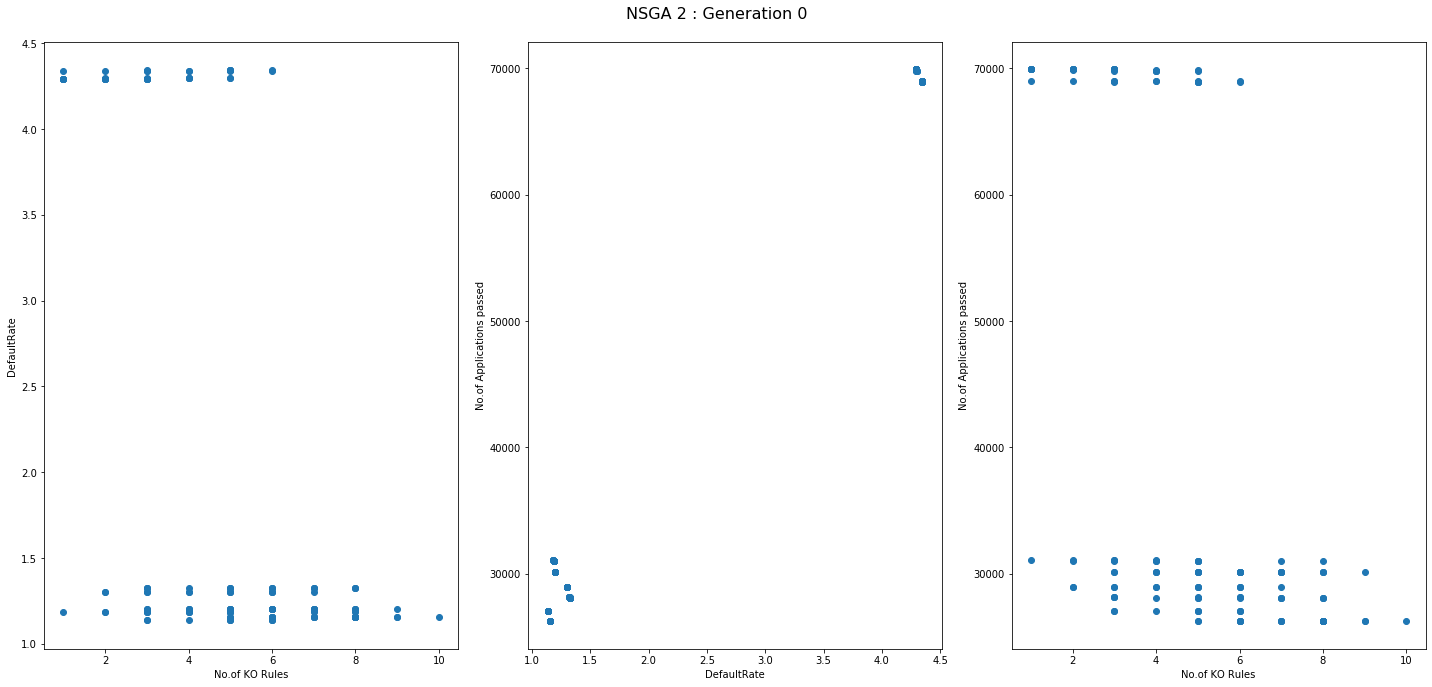

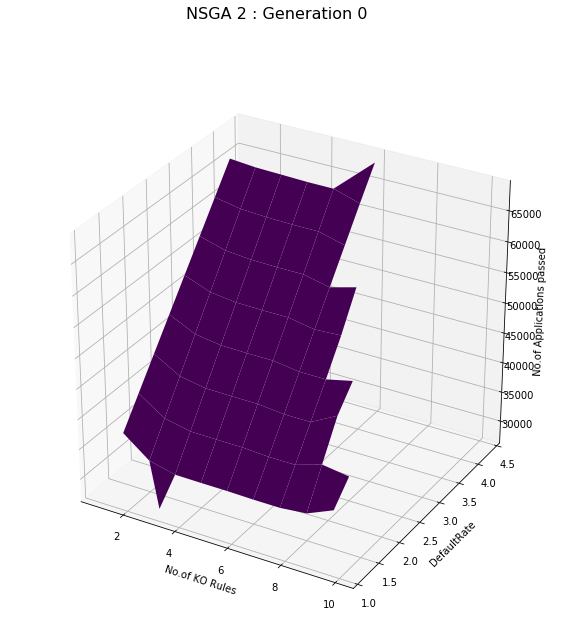

Generation 2 out of 30 


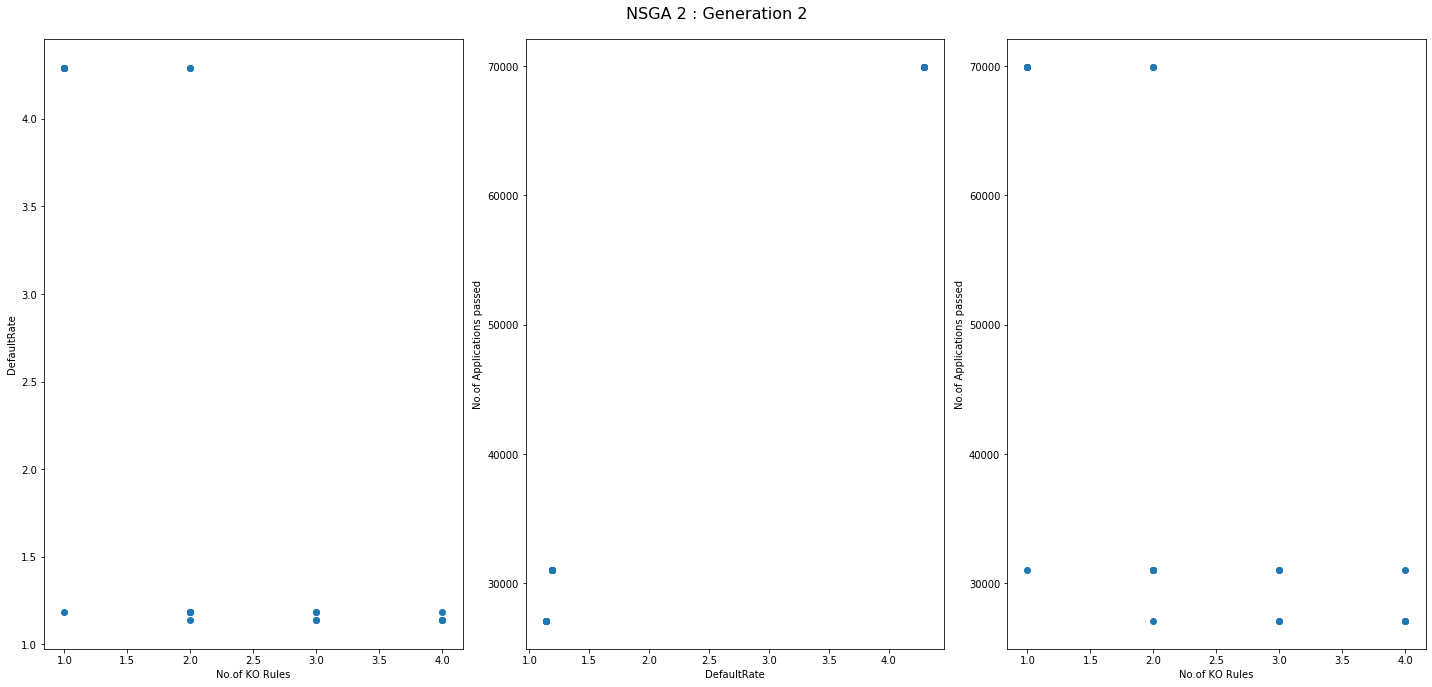

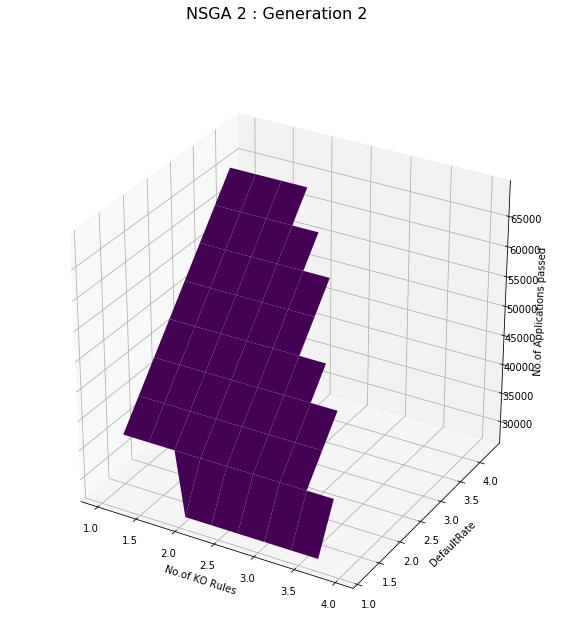

Generation 4 out of 30 


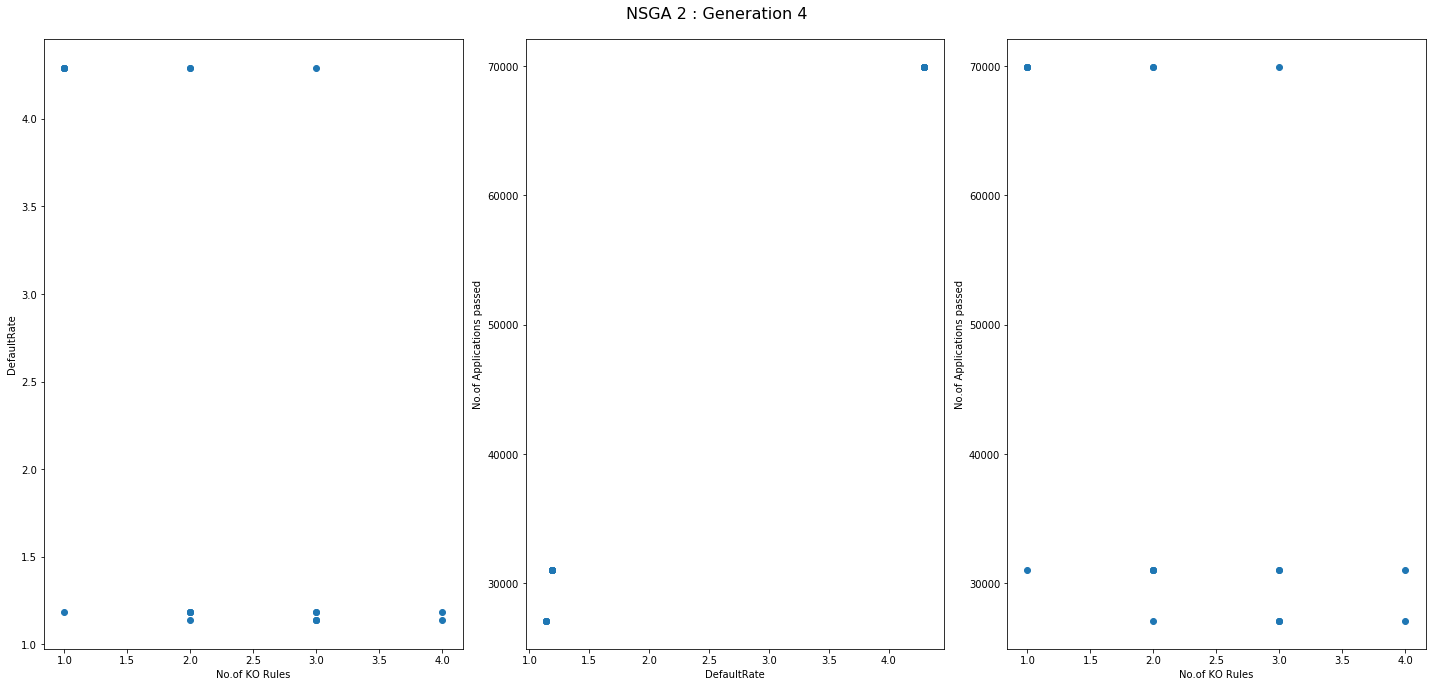

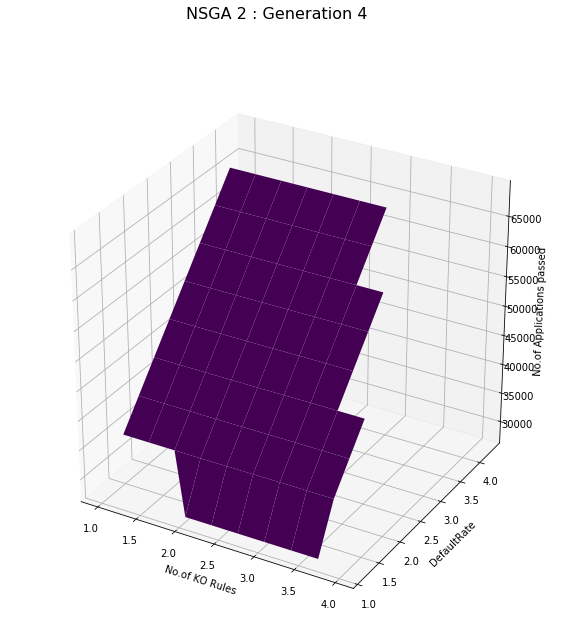

Generation 6 out of 30 


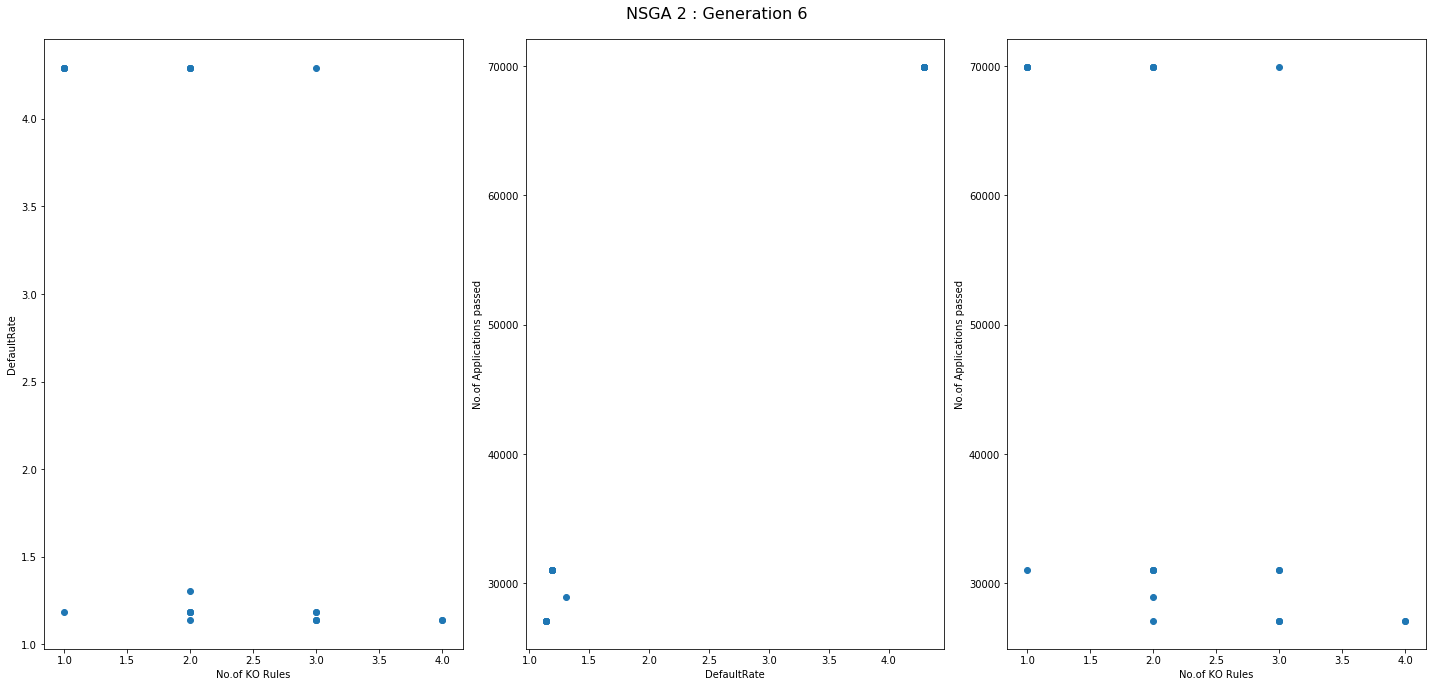

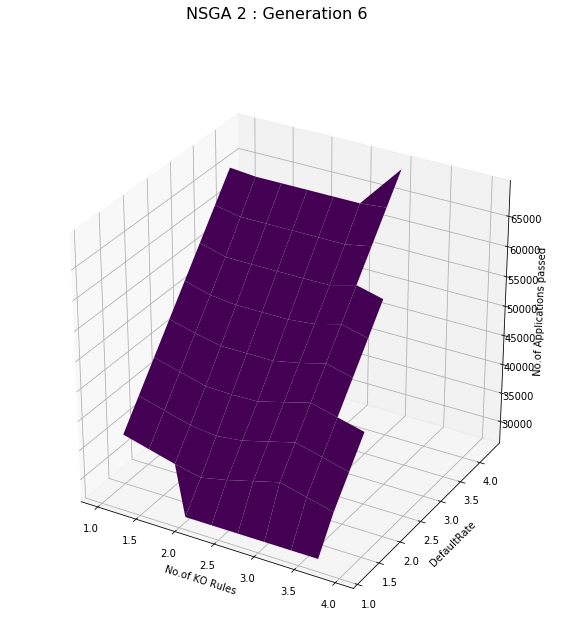

Generation 8 out of 30 


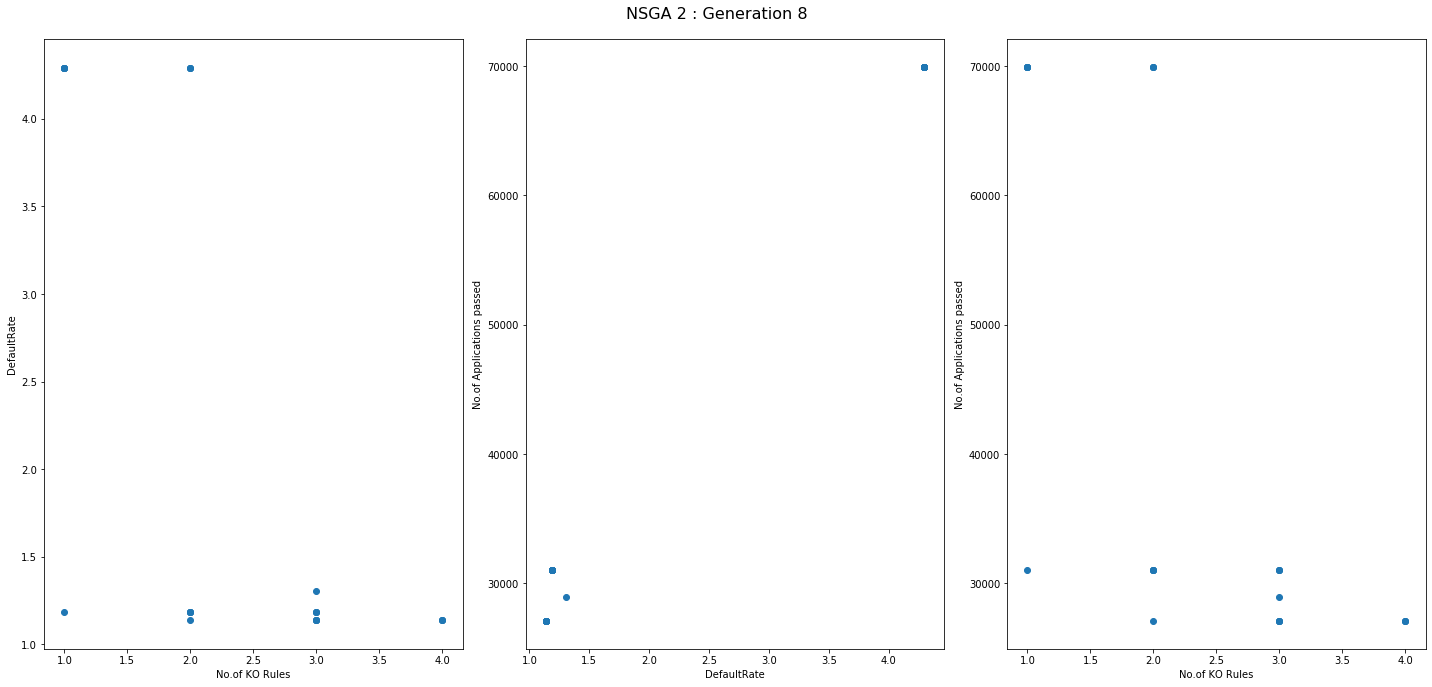

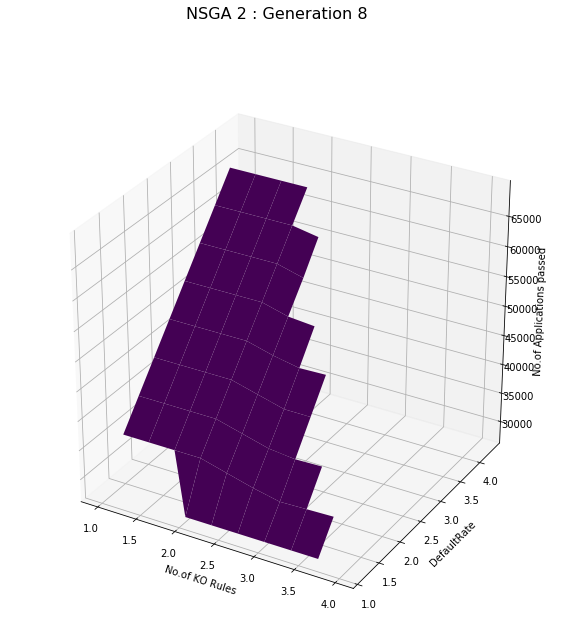

Generation 10 out of 30 


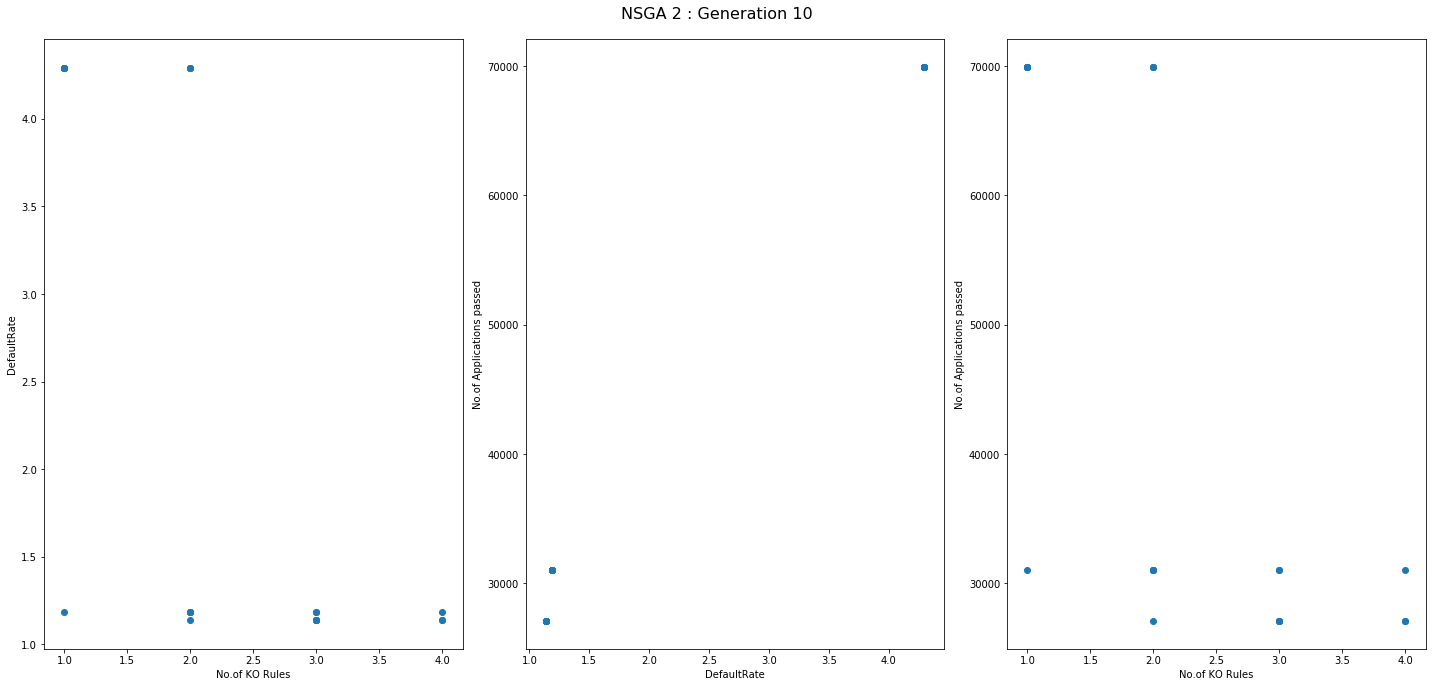

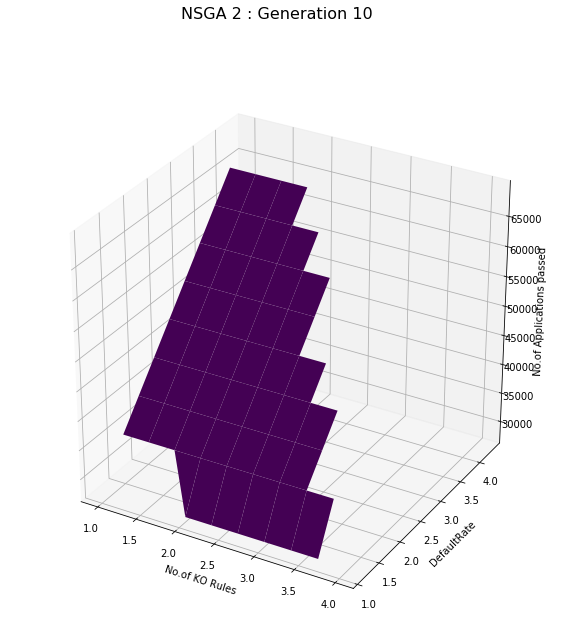

Generation 12 out of 30 


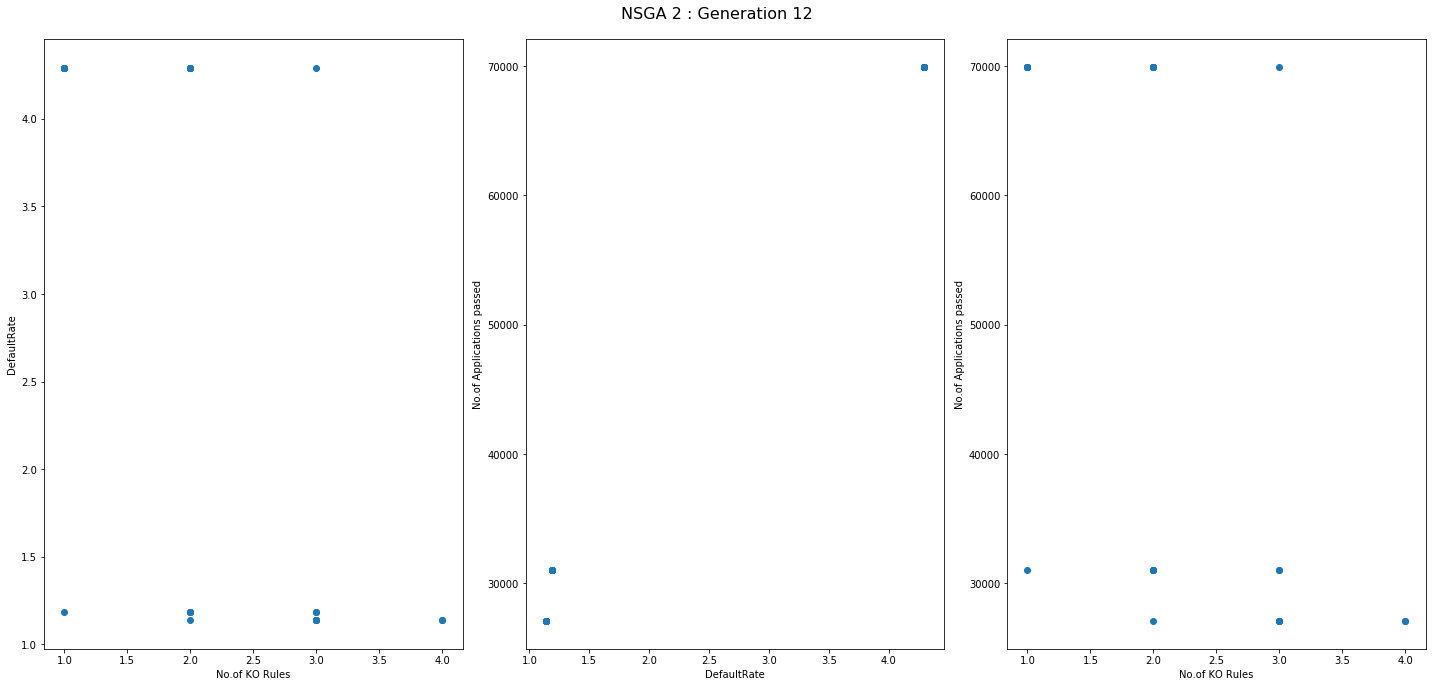

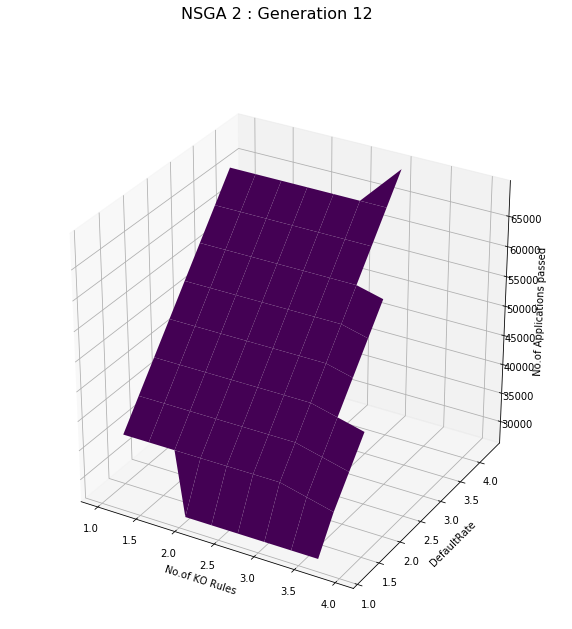

Generation 14 out of 30 


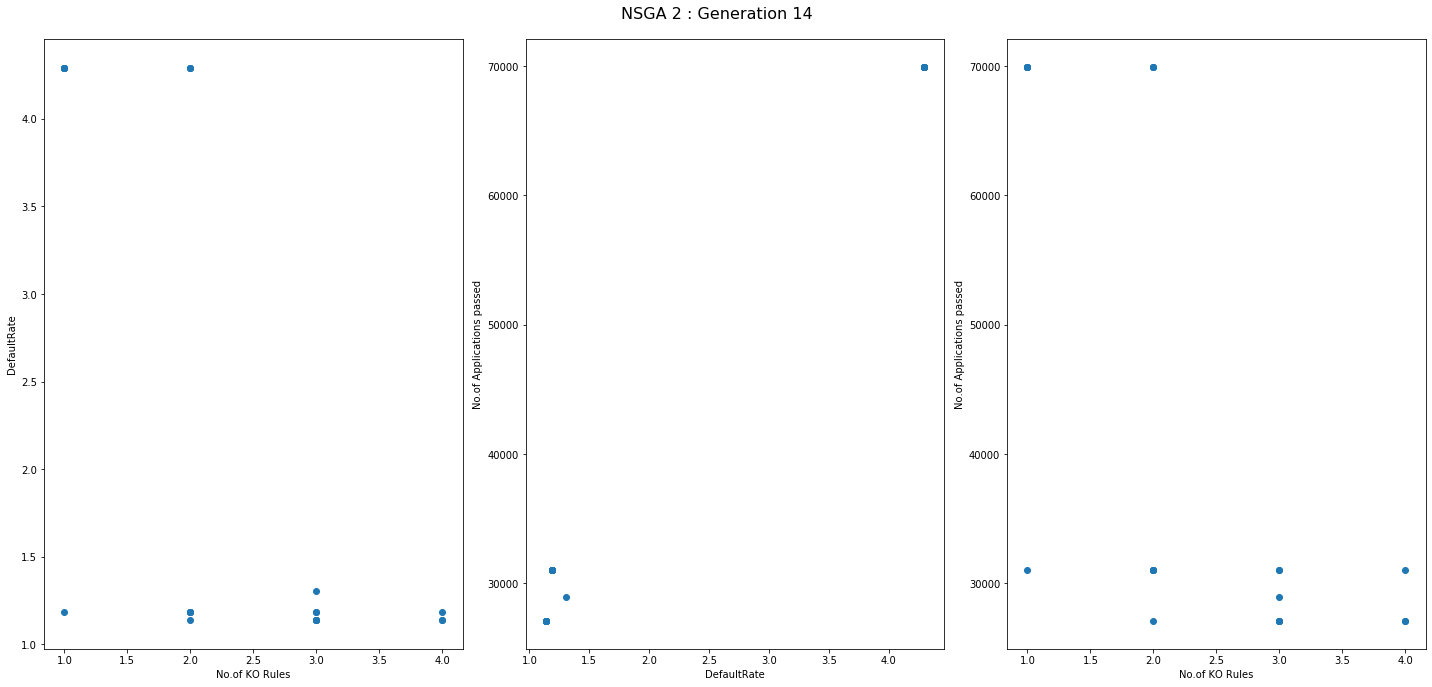

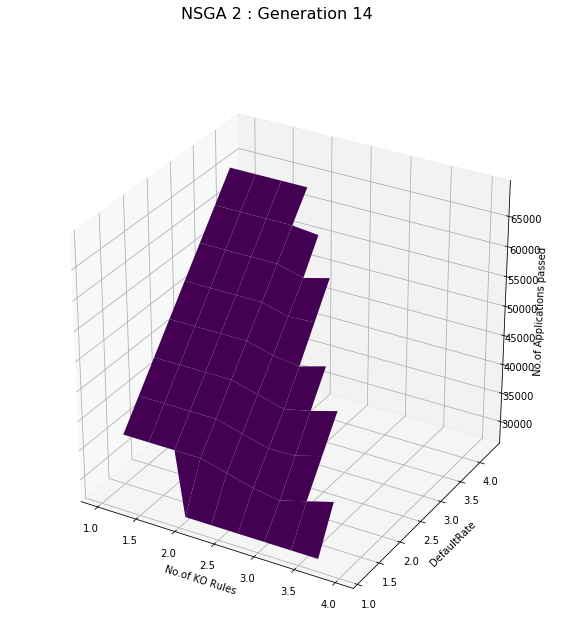

Generation 16 out of 30 


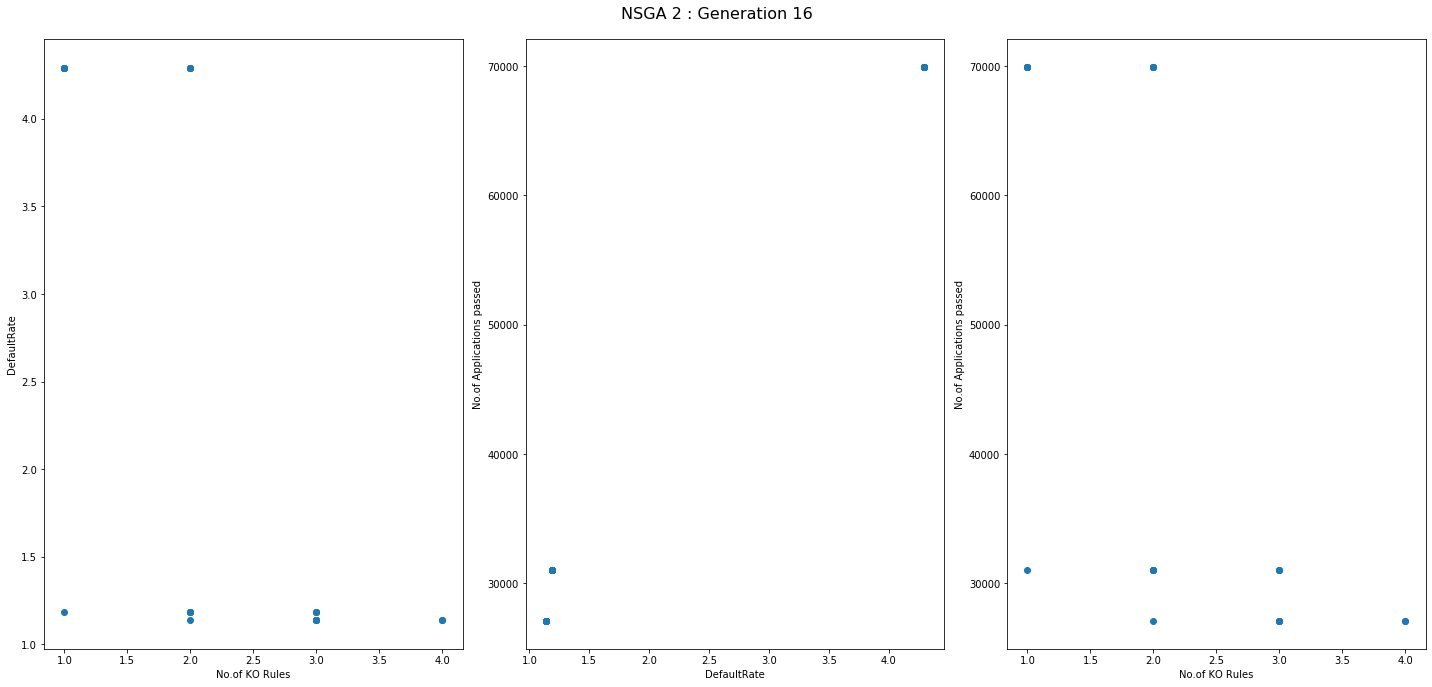

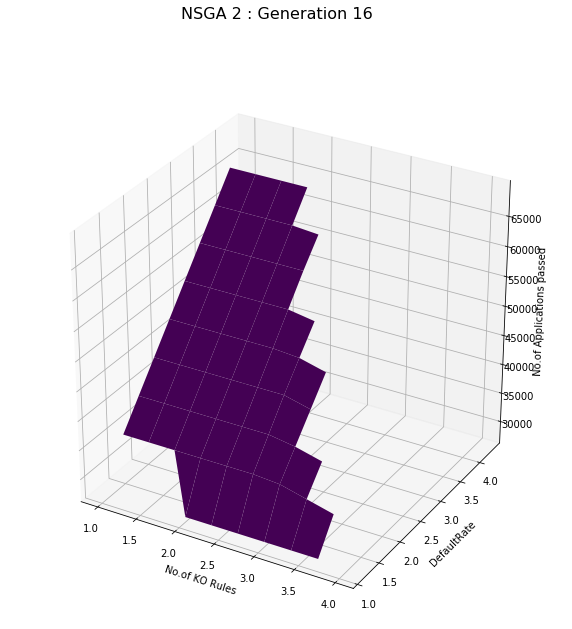

Generation 18 out of 30 


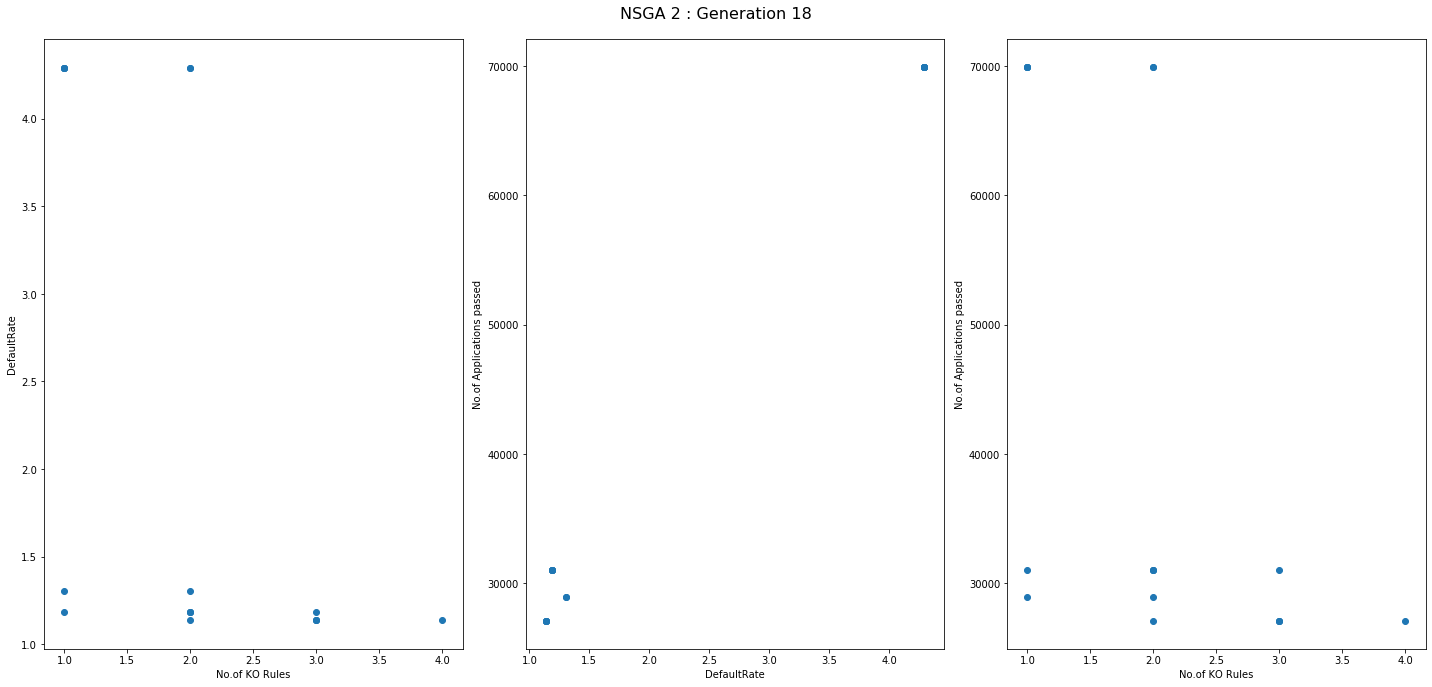

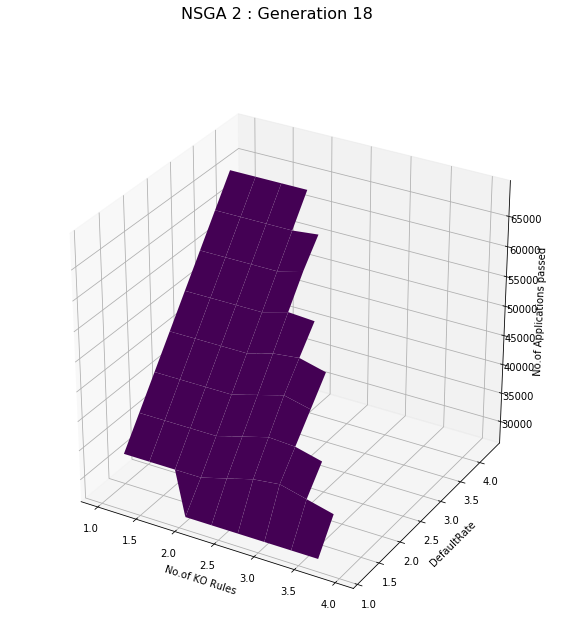

Generation 20 out of 30 


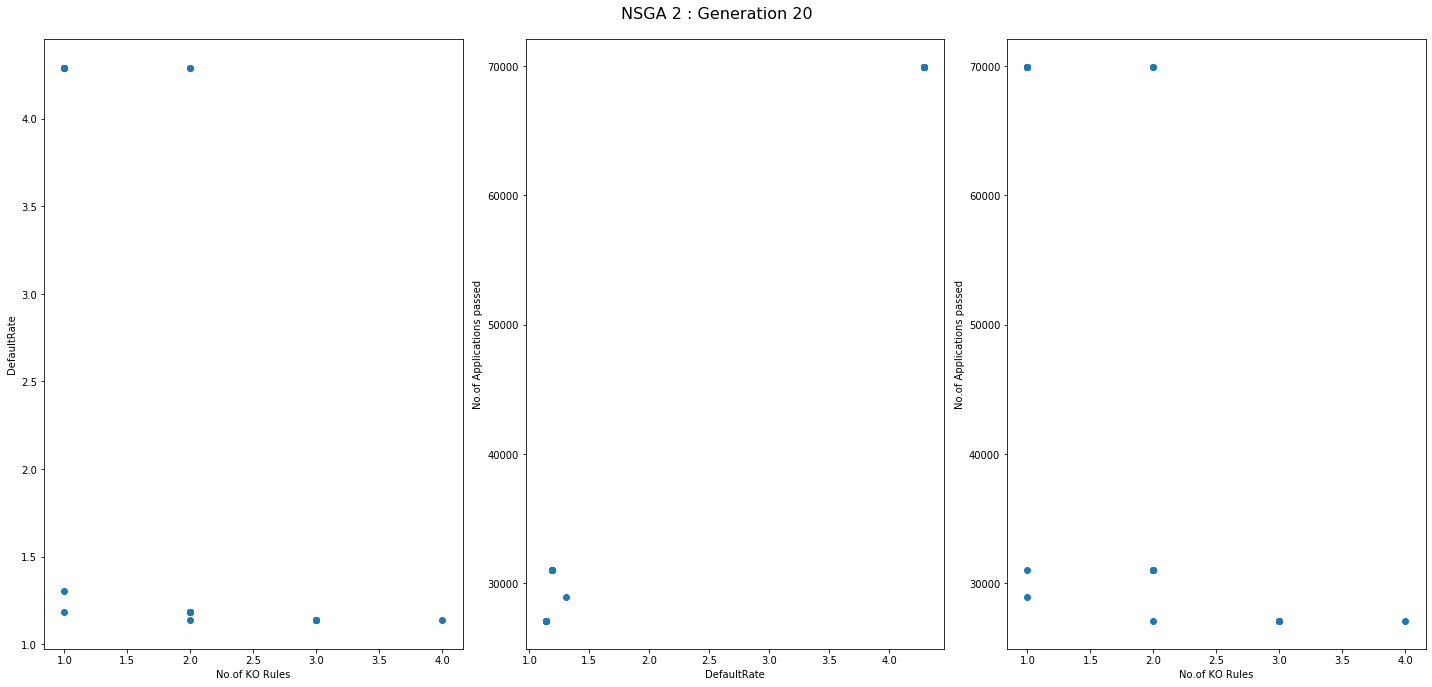

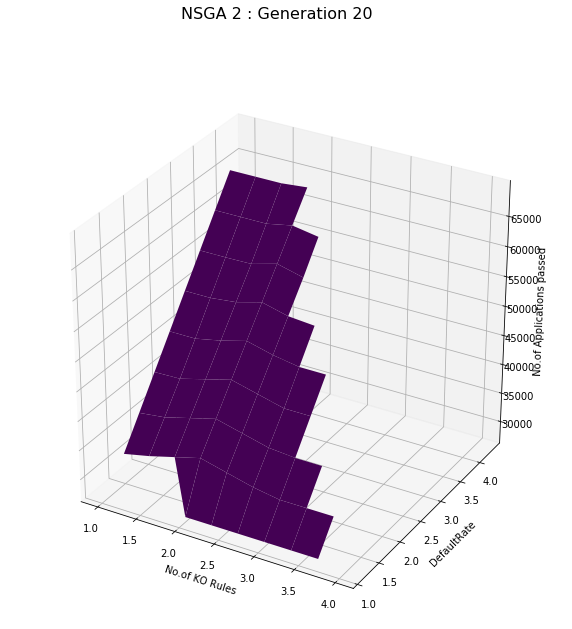

Generation 22 out of 30 


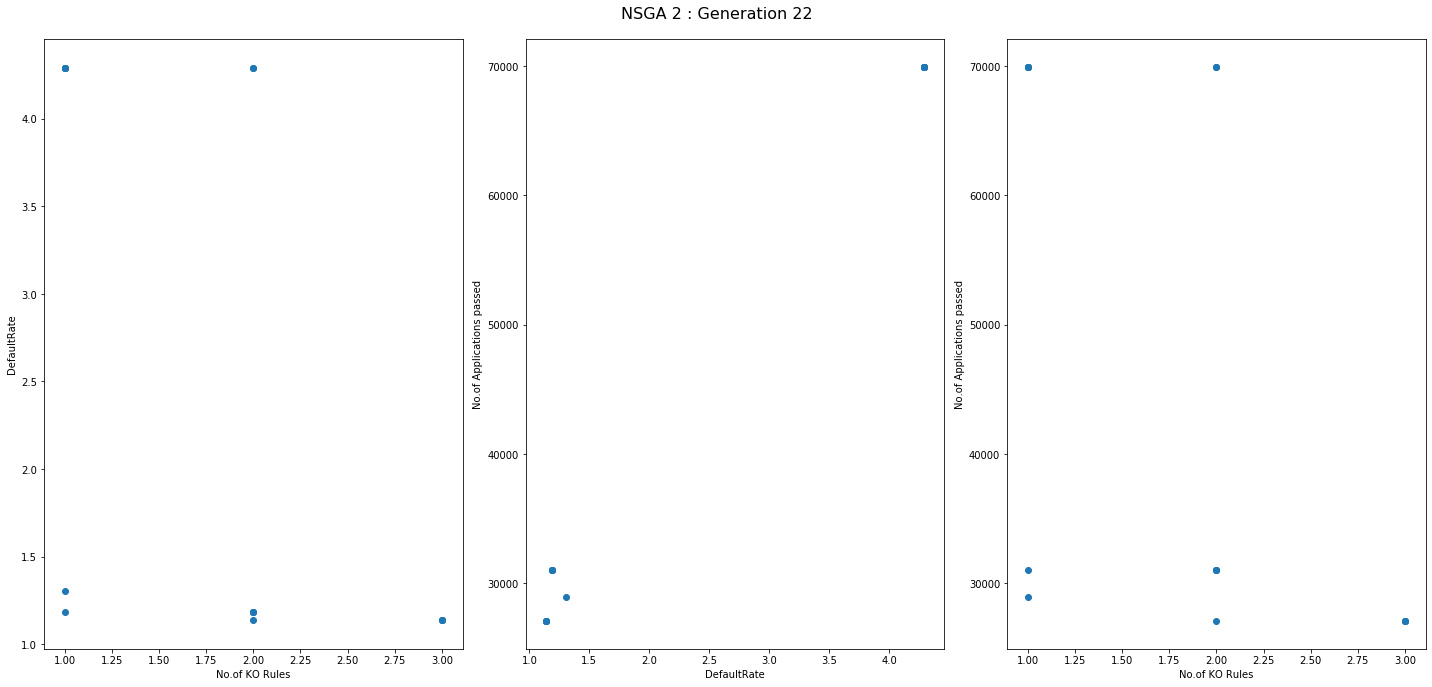

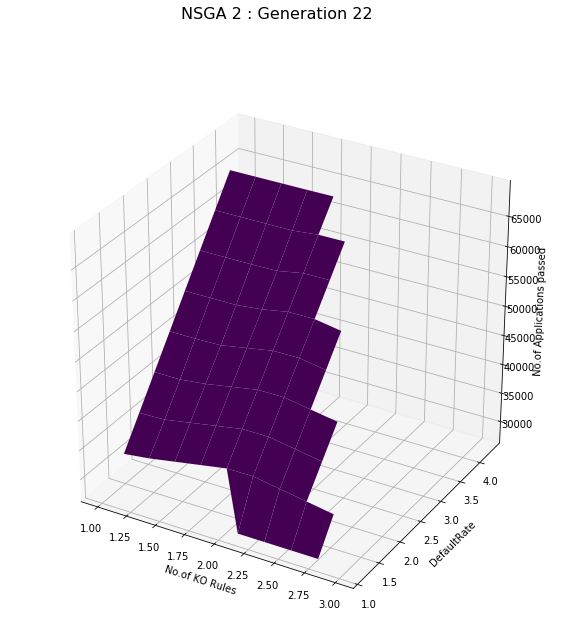

Generation 24 out of 30 


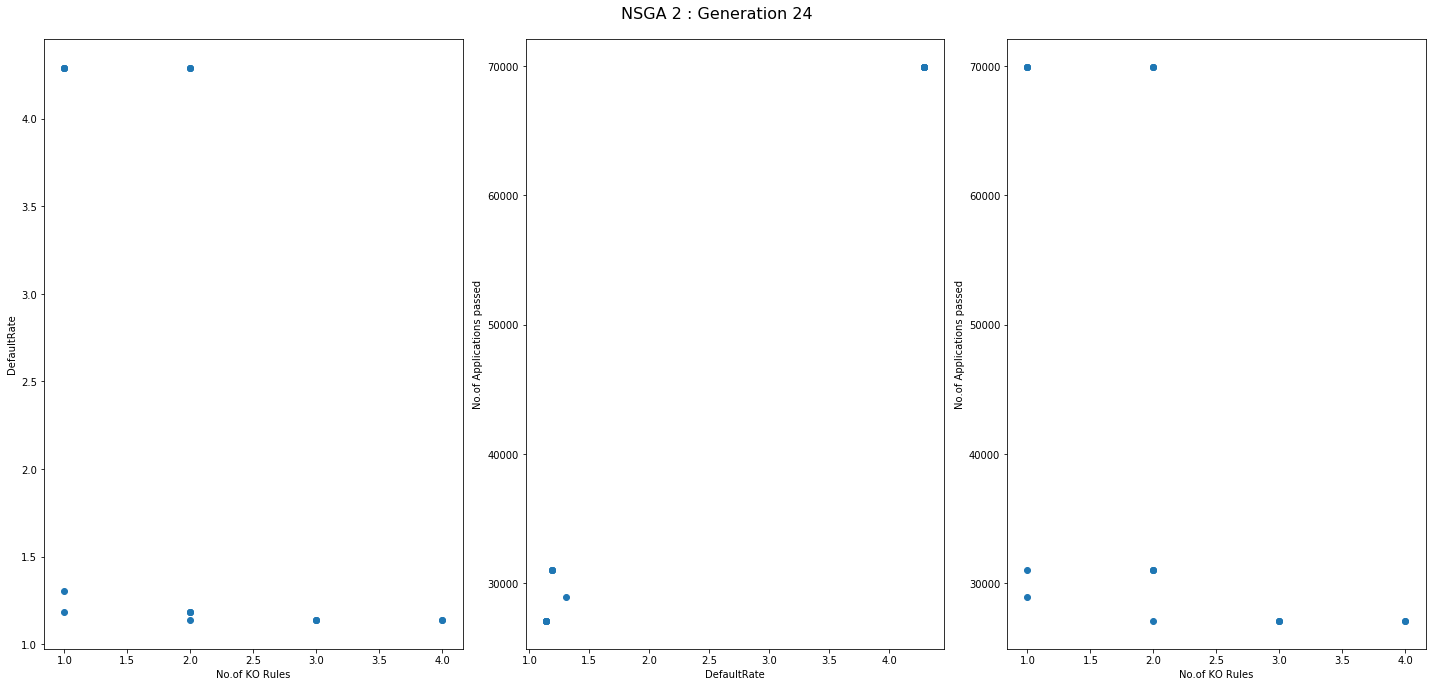

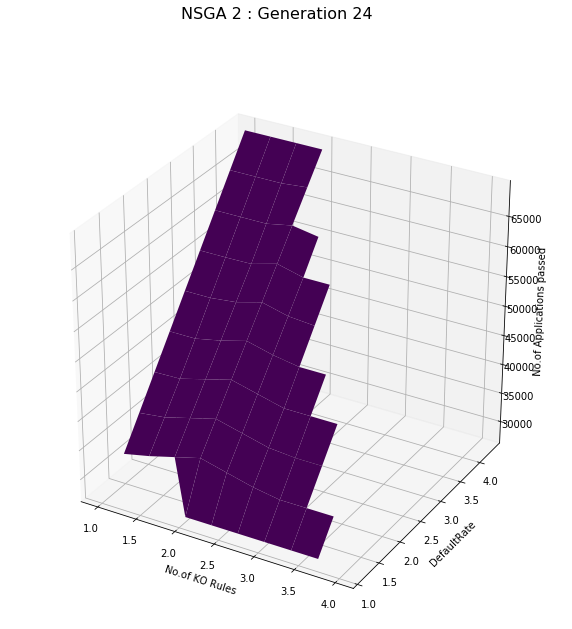

Generation 26 out of 30 


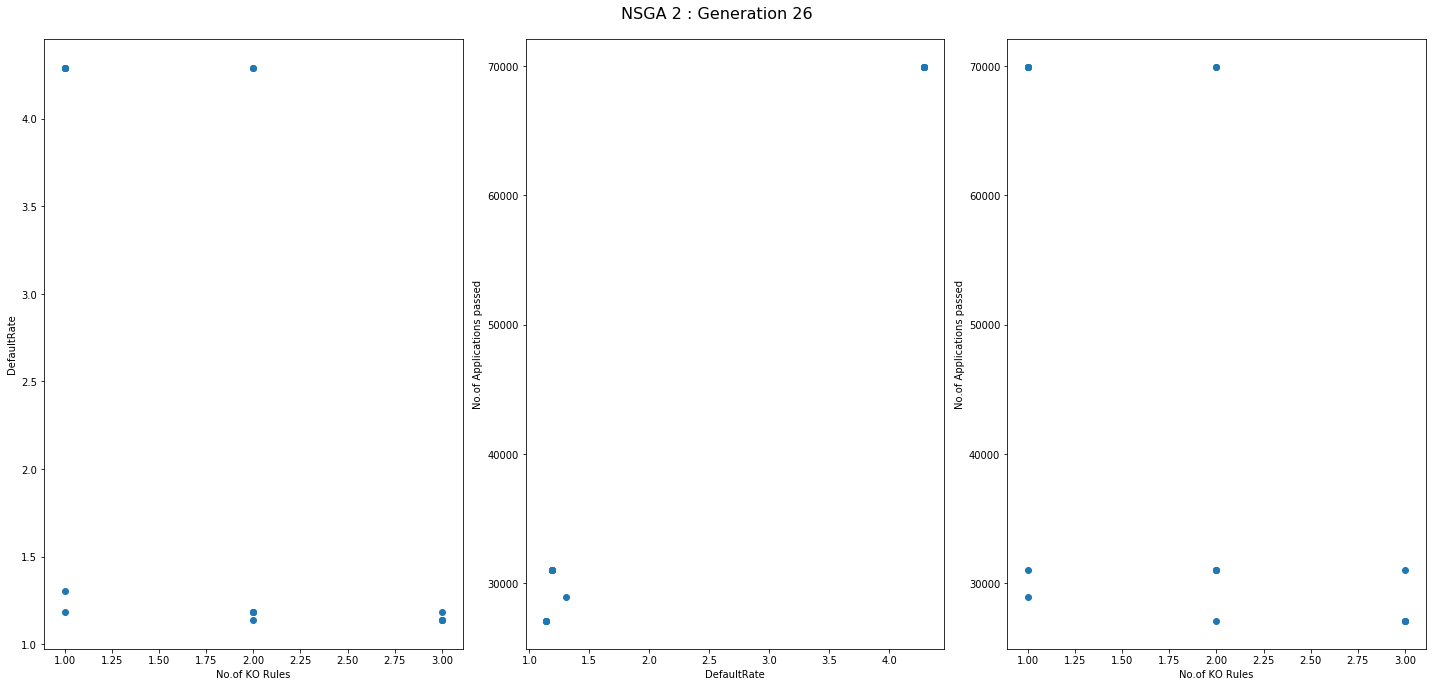

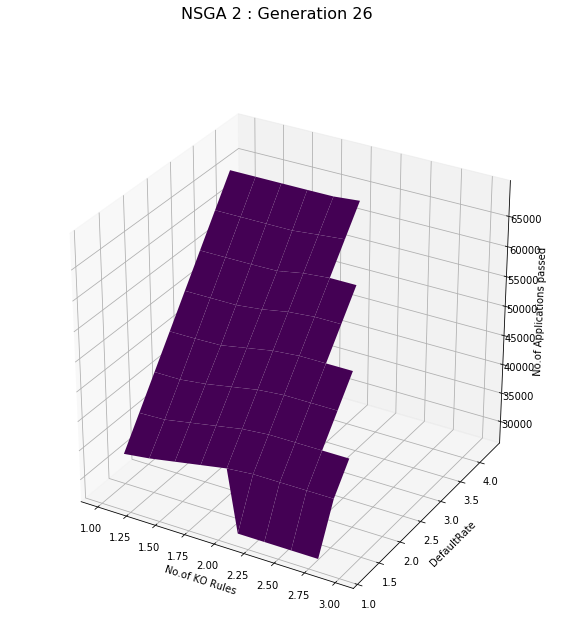

Generation 28 out of 30 


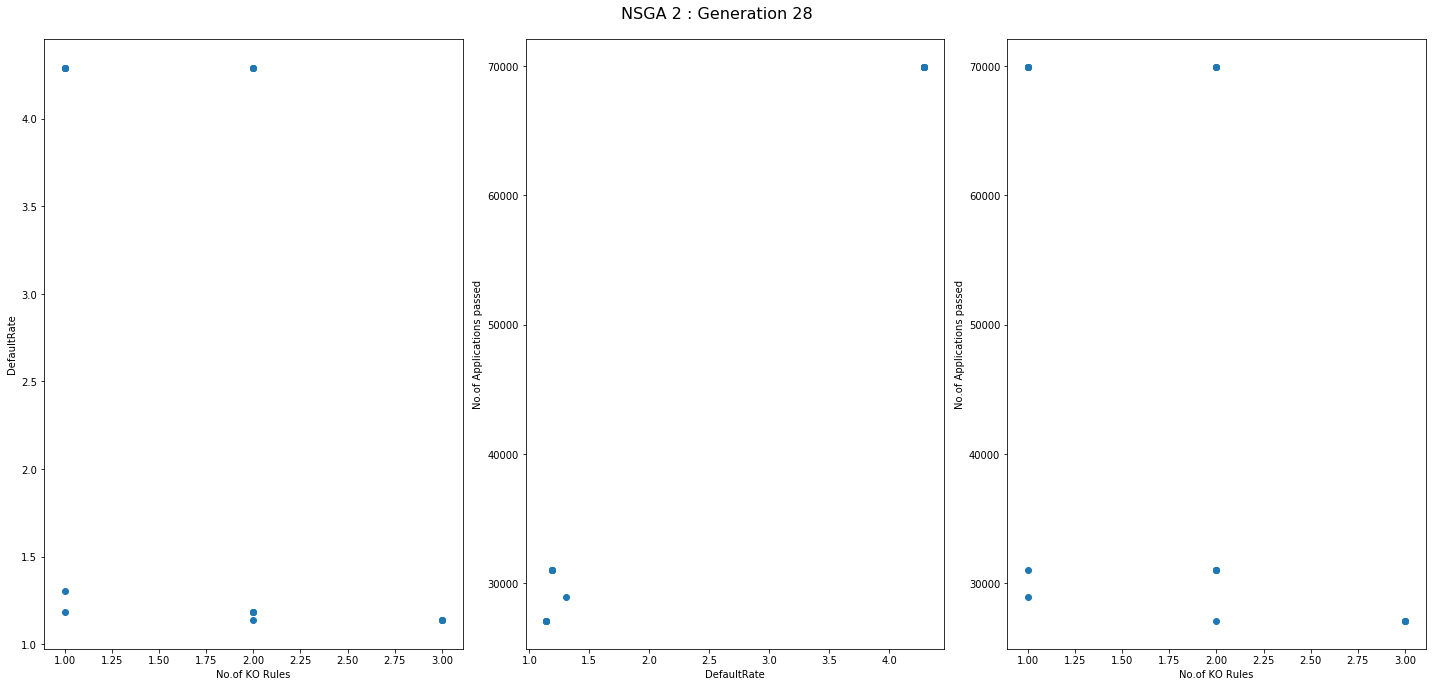

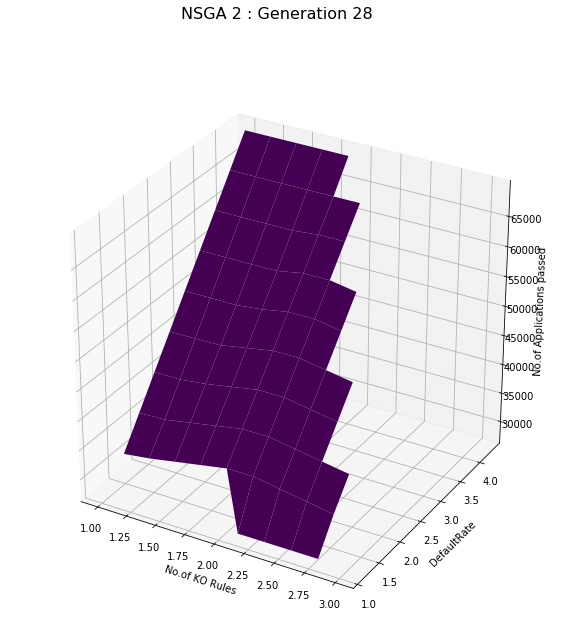

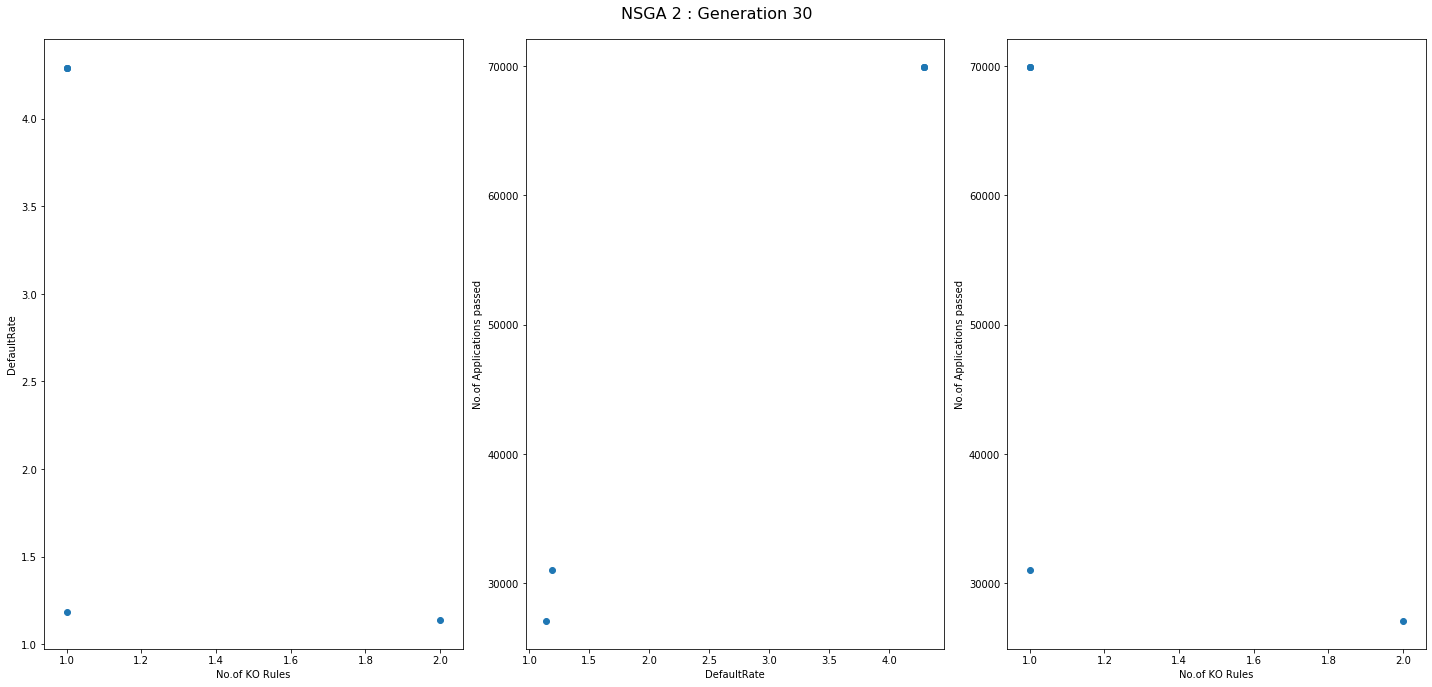

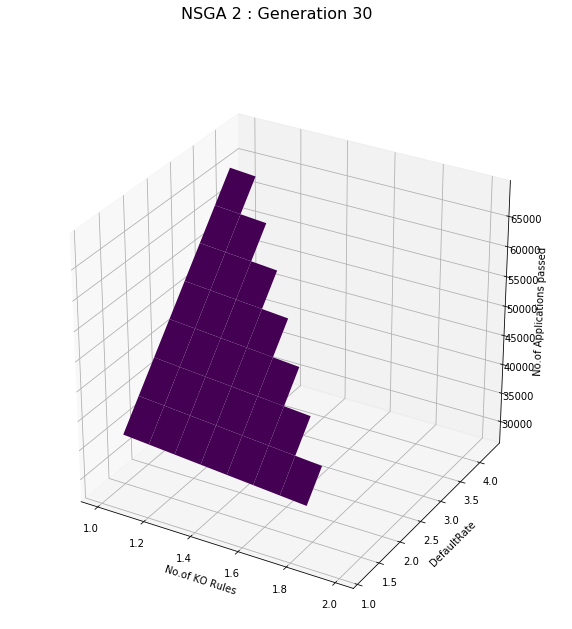

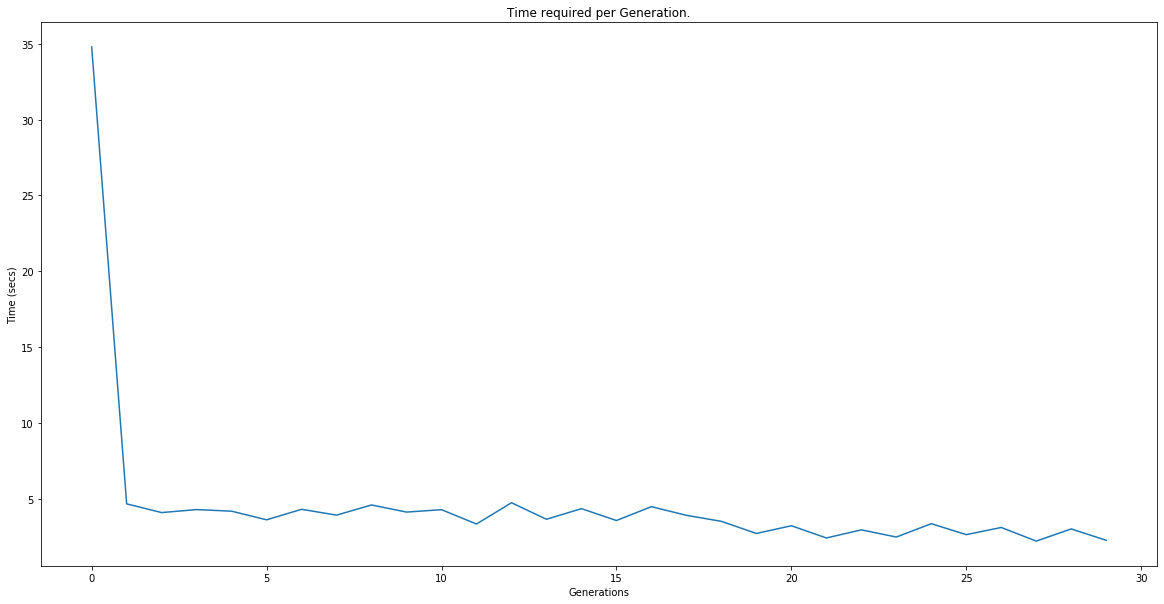

In [7]:
# Set general parameters
chromosome_length = len(all_rule_individual)
starting_population_size = 100
maximum_generation = 30
minimum_population_size = 15
maximum_population_size = 30
constraints=["No.of KO Rules","DefaultRate","No.of Applications passed"]

# Create starting population
population = ngsa2.create_population(starting_population_size,chromosome_length)
population = np.unique(population, axis=0)
# Now we'll go through the generations of genetic algorithm

generation_list = []
time_required = []

for generation in range(maximum_generation):
    start_time = time.time()
    
    # Breed
    population = ngsa2.breed_population(population)
    
    # Score population
    population,scores = ngsa2.score_population_with_trained_clf(X_optimize,y_optimize,
                                                                trained_model,population)
    
    # Build pareto front
    population = ngsa2.build_pareto_population(
            population, scores, minimum_population_size, maximum_population_size)
    
    if generation%2 == 0:
        print ('Generation {} out of {} '.format(generation,maximum_generation))
        ngsa2.plot_2d_paretofront(scores,generation,constraints)
        ngsa2.plot_3d_paretofront(scores,generation,constraints)
    
    time_taken = time.time()-start_time
    #print("{} secs for Generation {} ".format(time_taken,generation))
    
    generation_list.append(generation)
    time_required.append(time_taken)
    

# Get final pareto front
population,scores = ngsa2.score_population_with_trained_clf(X_optimize,y_optimize,
                                                            trained_model,population)
population_ids = np.arange(population.shape[0]).astype(int)
pareto_front = ngsa2.identify_pareto(scores, population_ids)
population = population[pareto_front, :]
scores = scores[pareto_front]

#Selected Population
ngsa2.plot_2d_paretofront(scores,generation+1,constraints)
ngsa2.plot_3d_paretofront(scores,generation+1,constraints)

#Plot time taken for calculation.
ngsa2.plot_gen_time(generation_list,time_required)

### Final Results

In [6]:
result_df = ngsa2.show_population_score_df(population,scores,column_name=["#Rules","DefaultRate(%)","No.ofApplications"])
default_rate = ngsa2.get_default_rate_for_delta_applications(population,X_optimize,y_optimize,trained_model)
result_df['Default Rate New applications(%)'] = default_rate
result_df.sort_values(by=['Default Rate New applications(%)'],ascending=True)

,#Rules,DefaultRate(%),No.ofApplications,Rules,Default Rate New applications(%)
1,2.0,1.137245,27083.0,"{6.0: 'avg_acct_age_m >= 6', 8.0: 'perform_cns_score >= 200'}",0.592417
0,1.0,1.185033,31054.0,{8.0: 'perform_cns_score >= 200'},1.349948
2,1.0,4.291821,69947.0,{3.0: 'delinquent_accts_in_last_six_months <=30'},6.176464
3,1.0,4.291821,69947.0,{2.0: 'ltv <= 95'},6.176464
4,1.0,4.291821,69947.0,{1.0: 'age_when_disbursal <= 840 '},6.176464
